In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
andel_avslag=df['Avslag_ind'].sum()/df['Avslag_ind'].count()

In [6]:
andel_avslag

0.030107526881720432

In [7]:
antall_avslag=df['Avslag_ind'].sum()

In [8]:
antall_avslag

28

In [9]:
df

,OBJ.VEGOBJEKT-ID,EGS.BRUKSOMRÅDE.1256,EGS.PRIMÆRAKTIVITET.1824,EGS.SIKTFORHOLD.12051,EGS.SAKSNUMMER.1822,EGS.SØKNAD MOTTATT DATO.12048,"EGS.ARKIVREFERANSE, URL.12050",EGS.VEDTAK.10670,EGS.VEDTAKSDATO.11444,EGS.TILLATELSE GJELDER TIL DATO.12049,...,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,"Avkjørsel, holdningsklasse",Funksjonsklasse,Avkjørsler,Trafikkulykker,"Kurvatur, horisontalelement","Kurvatur, stigning",Avslag_ind
0,1025223484,Bolig,NaN,4x100,2024/60677,14.05.2024,NaN,Varig tillatelse,19.02.2025,NaN,...,100.0,10.0,80.0,Lite streng,E - Lokale adkomstveger,0,0,-558.0,-2.7,0
1,1025236953,Bolig,NaN,6x45,2021/20963,05.01.2025,NaN,Varig tillatelse,08.01.2025,NaN,...,850.0,14.0,50.0,Lite streng,E - Lokale adkomstveger,0,4,-24.0,8.4,0
2,1025238261,Bolig,NaN,4x60,2023/71315,23.12.2023,NaN,Varig tillatelse,28.06.2024,NaN,...,800.0,10.0,60.0,Mindre streng,D - Lokale samleveger,0,0,99999.0,3.7,0
3,1025214056,Industri,NaN,6x45,2025/9557,14.01.2025,NaN,Midlertidig tillatelse,03.02.2025,31.12.2025,...,6400.0,12.0,50.0,Meget streng,C - Lokale hovedveger,0,23,99999.0,-0.7,0
4,1025236984,Bolig,NaN,4x45,2024/56258,23.04.2024,NaN,Varig tillatelse,13.05.2024,NaN,...,600.0,14.0,50.0,Lite streng,D - Lokale samleveger,1,2,99999.0,-1.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,1016361352,Bolig,NaN,NaN,202435243-2,08.07.2024,https://trondelag.public360online.com/locator/...,Avslag,06.09.2024,06.09.2027,...,1300.0,6.0,30.0,Lite streng,E - Lokale adkomstveger,21,0,-1520.0,-0.5,1
926,1022497081,Gardsbruk,NaN,NaN,202516520-2,21.03.2025,https://trondelag.public360online.com/locator/...,Varig tillatelse,02.04.2025,02.04.2028,...,500.0,10.0,60.0,Mindre streng,D - Lokale samleveger,12,2,-1119.0,0.2,0
927,1018366642,Bolig,NaN,NaN,202340342-4,03.01.2024,https://trondelag.public360online.com/locator/...,Varig tillatelse,08.01.2024,08.01.2027,...,400.0,13.0,60.0,Streng,C - Lokale hovedveger,12,0,-192.0,5.5,0
928,1018305147,Skog/skogbruk,NaN,NaN,202337403-4,10.10.2023,https://trondelag.public360online.com/locator/...,Varig tillatelse,25.10.2023,25.10.2026,...,1600.0,15.0,80.0,Streng,B - Regionale hovedveger,8,6,-524.0,-3.0,0


In [10]:
df["Kurvatur, horisontal"]=df["Kurvatur, horisontalelement"]

In [11]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "EGS.SIKTFORHOLD.12051",
    "Kurvatur, stigning"
]
df=df[features]
# Encode categorical features

In [12]:
# Funksjon for å trekke ut siktlengde
def extract_sikt(val):
    if pd.isna(val):
        return np.nan
    val = val.strip().lower()
    if 'god' in val:
        return None  # vil kategorisere som lang sikt
    # Finn alle tall i teksten
    match = re.findall(r'\d+', val)
    if match:
        sikt_m = max(int(x) for x in match)  # tar lengste som representativ
        return sikt_m
    return None

df['sikt_m'] = df['EGS.SIKTFORHOLD.12051'].apply(extract_sikt)

# Lag kategoriske variabler direkte
def kategoriser_sikt(val, original):
    if pd.isna(original):
        return 'ukjent sikt'
    if val is None or ('god' in str(original).lower()):
        return 'lang sikt'
    elif val < 50:
        return 'kort sikt'
    elif val <= 99:
        return 'middels sikt'
    else:
        return 'lang sikt'

#df['sikt_kategori'] = df.apply(lambda row: kategoriser_sikt(row['sikt_m'], row['EGS.SIKTFORHOLD.12051']), axis=1)
df = df.drop(['EGS.SIKTFORHOLD.12051','sikt_m'], axis=1)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\3441133011.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sikt_m'] = df['EGS.SIKTFORHOLD.12051'].apply(extract_sikt)


In [13]:
df_encoded=pd.get_dummies(df)

In [14]:
df_encoded

,Avslag_ind,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Kurvatur, horisontal","Kurvatur, stigning","Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng",...,EGS.BRUKSOMRÅDE.1256_Dyrkamark/jordbruk,EGS.BRUKSOMRÅDE.1256_Forretning,EGS.BRUKSOMRÅDE.1256_Fritidsaktivitet,EGS.BRUKSOMRÅDE.1256_Gardsbruk,EGS.BRUKSOMRÅDE.1256_Hytte,EGS.BRUKSOMRÅDE.1256_Industri,EGS.BRUKSOMRÅDE.1256_Naust,EGS.BRUKSOMRÅDE.1256_Service,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage
0,0,100.0,10.0,80.0,0,0,-558.0,-2.7,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,850.0,14.0,50.0,0,4,-24.0,8.4,True,False,...,False,False,False,False,False,False,False,False,False,False
2,0,800.0,10.0,60.0,0,0,99999.0,3.7,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,6400.0,12.0,50.0,0,23,99999.0,-0.7,False,True,...,False,False,False,False,False,True,False,False,False,False
4,0,600.0,14.0,50.0,1,2,99999.0,-1.8,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,1,1300.0,6.0,30.0,21,0,-1520.0,-0.5,True,False,...,False,False,False,False,False,False,False,False,False,False
926,0,500.0,10.0,60.0,12,2,-1119.0,0.2,False,False,...,False,False,False,True,False,False,False,False,False,False
927,0,400.0,13.0,60.0,12,0,-192.0,5.5,False,False,...,False,False,False,False,False,False,False,False,False,False
928,0,1600.0,15.0,80.0,8,6,-524.0,-3.0,False,False,...,False,False,False,False,False,False,False,False,True,False


In [15]:
df_encoded=df_encoded.dropna()

In [16]:
df

,Avslag_ind,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,"Avkjørsel, holdningsklasse",Funksjonsklasse,Avkjørsler,Trafikkulykker,EGS.BRUKSOMRÅDE.1256,"Kurvatur, horisontal","Kurvatur, stigning"
0,0,100.0,10.0,80.0,Lite streng,E - Lokale adkomstveger,0,0,Bolig,-558.0,-2.7
1,0,850.0,14.0,50.0,Lite streng,E - Lokale adkomstveger,0,4,Bolig,-24.0,8.4
2,0,800.0,10.0,60.0,Mindre streng,D - Lokale samleveger,0,0,Bolig,99999.0,3.7
3,0,6400.0,12.0,50.0,Meget streng,C - Lokale hovedveger,0,23,Industri,99999.0,-0.7
4,0,600.0,14.0,50.0,Lite streng,D - Lokale samleveger,1,2,Bolig,99999.0,-1.8
...,...,...,...,...,...,...,...,...,...,...,...
925,1,1300.0,6.0,30.0,Lite streng,E - Lokale adkomstveger,21,0,Bolig,-1520.0,-0.5
926,0,500.0,10.0,60.0,Mindre streng,D - Lokale samleveger,12,2,Gardsbruk,-1119.0,0.2
927,0,400.0,13.0,60.0,Streng,C - Lokale hovedveger,12,0,Bolig,-192.0,5.5
928,0,1600.0,15.0,80.0,Streng,B - Regionale hovedveger,8,6,Skog/skogbruk,-524.0,-3.0


In [17]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\354339799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)


In [18]:
df_encoded['sving'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, df_encoded['Kurvatur, horisontal'].abs(), 0)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\898916879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['sving'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, df_encoded['Kurvatur, horisontal'].abs(), 0)


In [19]:
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\811313900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)


In [20]:
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\2119347968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)


In [21]:
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\4044815198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()


In [22]:
df_encoded['bakke_sigmoid'] = 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs()))

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\567083512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['bakke_sigmoid'] = 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs()))


In [23]:
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\211979289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100


In [24]:
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)

In [25]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [26]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Service,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage,sving_ind,sving,bakke_ind,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj
0,100.0,10.0,80.0,0,0,True,False,False,False,False,...,False,False,False,1,558.0,1,0.635990,2.7,0.635990,10.0
1,850.0,14.0,50.0,0,4,True,False,False,False,False,...,False,False,False,1,24.0,1,0.506000,8.4,0.506000,119.0
2,800.0,10.0,60.0,0,0,False,False,True,False,False,...,False,False,False,0,0.0,1,0.000000,3.7,1.000000,80.0
3,6400.0,12.0,50.0,0,23,False,True,False,False,False,...,False,False,False,0,0.0,1,0.000000,0.7,1.000000,768.0
4,600.0,14.0,50.0,1,2,True,False,False,False,False,...,False,False,False,0,0.0,1,0.000000,1.8,1.000000,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,1300.0,6.0,30.0,21,0,True,False,False,False,False,...,False,False,False,1,1520.0,1,0.820538,0.5,0.820538,78.0
926,500.0,10.0,60.0,12,2,False,False,True,False,False,...,False,False,False,1,1119.0,1,0.753803,0.2,0.753803,50.0
927,400.0,13.0,60.0,12,0,False,False,False,True,False,...,False,False,False,1,192.0,1,0.547853,5.5,0.547853,52.0
928,1600.0,15.0,80.0,8,6,False,False,False,True,False,...,False,True,False,1,524.0,1,0.628083,3.0,0.628083,240.0


In [27]:
poly = PolynomialFeatures(5, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [28]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,sving_ind bakke_ind sving_sigmoid bakke antall_lange_kj,sving_ind bakke_ind sving_sigmoid bakke_sigmoid antall_lange_kj,sving_ind bakke_ind bakke bakke_sigmoid antall_lange_kj,sving_ind sving_sigmoid bakke bakke_sigmoid antall_lange_kj,sving bakke_ind sving_sigmoid bakke bakke_sigmoid,sving bakke_ind sving_sigmoid bakke antall_lange_kj,sving bakke_ind sving_sigmoid bakke_sigmoid antall_lange_kj,sving bakke_ind bakke bakke_sigmoid antall_lange_kj,sving sving_sigmoid bakke bakke_sigmoid antall_lange_kj,bakke_ind sving_sigmoid bakke bakke_sigmoid antall_lange_kj
0,100.0,10.0,80.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,17.171721,4.044828,17.171721,10.921037,609.393844,9581.820108,2257.014238,9581.820108,6093.938443,10.921037
1,850.0,14.0,50.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,505.797312,30.468249,505.797312,255.933294,51.616799,12139.135491,731.237984,12139.135491,6142.399063,255.933294
2,800.0,10.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,6400.0,12.0,50.0,0.0,23.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,600.0,14.0,50.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,1300.0,6.0,30.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,32.001001,52.516105,32.001001,26.258053,511.695383,48641.521130,79824.479683,48641.521130,39912.239841,26.258053
852,500.0,10.0,60.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,...,7.538032,28.410962,7.538032,5.682192,127.167464,8435.057580,31791.866119,8435.057580,6358.373224,5.682192
853,400.0,13.0,60.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,...,156.685982,15.607436,156.685982,85.840899,316.951012,30083.708634,2996.627746,30083.708634,16481.452600,85.840899
854,1600.0,15.0,80.0,8.0,6.0,0.0,0.0,0.0,1.0,0.0,...,452.219489,94.677068,452.219489,284.031203,620.134793,236963.012152,49610.783440,236963.012152,148832.350319,284.031203


In [29]:
andel_avslag=y.sum()/y.count()

In [30]:
#X=df_with_interactions
#scaler = PowerTransformer()
#X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [31]:
# Identify binary dummy columns: only {0,1} or {0.0,1.0}
binary_cols = [
    col for col in X.columns
    if np.isin(X[col].dropna().unique(), [0,1]).all()
]

continuous_cols = [col for col in X.columns if col not in binary_cols]

# Transform only continuous columns
scaler = PowerTransformer()
X_cont_scaled = pd.DataFrame(
    scaler.fit_transform(X[continuous_cols]),
    columns=continuous_cols,
    index=X.index
)

# Combine back into full feature matrix
X = pd.concat([X_cont_scaled, X[binary_cols]], axis=1)

In [32]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,sving,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj,...,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind sving_sigmoid bakke,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind sving_sigmoid bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind sving_sigmoid antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind bakke bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind bakke antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind bakke_sigmoid antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid bakke bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid bakke antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid bakke_sigmoid antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke bakke_sigmoid antall_lange_kj
0,-1.723294,0.029680,1.088215,-1.569219,-1.048636,0.991172,0.852758,0.236383,-0.711888,-1.665175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.383912,0.950345,-1.027326,-1.569219,1.079252,-0.106715,0.462071,1.698913,-1.354748,0.671953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.329036,0.029680,-0.377069,-1.569219,-1.048636,-1.123036,-1.139155,0.613695,1.064664,0.315548,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.063733,0.534235,-1.027326,-1.569219,1.872248,-1.123036,-1.139155,-1.000100,1.064664,2.222125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.064912,0.950345,-1.027326,-1.160739,0.611224,-1.123036,-1.139155,-0.205003,1.064664,0.359820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,0.760973,-1.443492,-2.136054,1.379377,-1.048636,1.371481,1.395926,-1.200520,0.192875,0.292522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
852,-0.105697,0.029680,-0.377069,0.620790,0.611224,1.253764,1.200974,-1.558818,-0.133283,-0.117542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
853,-0.317948,0.751545,-0.377069,0.620790,-1.048636,0.601686,0.588643,1.122815,-1.147229,-0.080960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
854,0.940522,1.133297,1.088215,0.169913,1.317421,0.967778,0.829193,0.359500,-0.750854,1.279139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
model = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
# Select top 10 features
top_features = importances_sorted.index[:15]
#X = X[top_features]

In [34]:
#importances_sorted

In [35]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)

# Auto-generate names: PC1, PC2, ..., PCn
pc_names = [f"PC{i+1}" for i in range(n_components)]

X_pca_df = pd.DataFrame(X_pca, columns=pc_names, index=X.index)

print("Explained variance ratio:", sum(pca.explained_variance_ratio_))
print("Shape after PCA:", X_pca_df.shape)
print(X_pca_df.head())
##X=X_pca_df

Explained variance ratio: 0.909195990108334
Shape after PCA: (856, 100)
         PC1        PC2        PC3        PC4       PC5        PC6        PC7  \
0 -43.473841 -32.135077  20.751279  -5.538796 -1.036973 -17.692535   4.212062   
1 -40.993639 -41.458922  55.832012 -12.461673 -4.947632 -27.406587   7.234474   
2 -20.809448  16.090624 -40.521657   9.287891  0.356995  -8.395252  -3.156135   
3   0.402180  -5.810458 -52.896584  14.161140 -0.968157   5.995952 -17.371607   
4 -26.668693   7.427411 -30.741286   7.270036 -0.593785 -15.076268  -0.383154   

         PC8        PC9       PC10  ...       PC91       PC92       PC93  \
0  11.791058 -15.531418  -3.445239  ...   8.860475   1.033444  -2.878187   
1  21.373214 -22.430411  -2.439721  ...   7.590163  -5.264411   3.086044   
2   3.173894  -7.285457  -0.091825  ...  -3.766162   8.298963  -4.402139   
3  10.869541  -9.578472  20.538384  ... -10.589434 -25.284018  23.955800   
4  13.725879 -13.554844  -1.947559  ... -19.760081  -3.891683

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
y_train.sum()

13

In [38]:
y_test.sum()

9

In [39]:
X_train_orig=X_train
y_train_orig=y_train

In [40]:
smote = ADASYN(sampling_strategy=0.3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [41]:
# Fit logistic regression
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [42]:
y_test

782    0
670    0
140    0
230    0
415    0
      ..
789    0
551    0
459    1
262    0
155    0
Name: Avslag_ind, Length: 257, dtype: int64

In [43]:
yps=model.predict_proba(X_test)

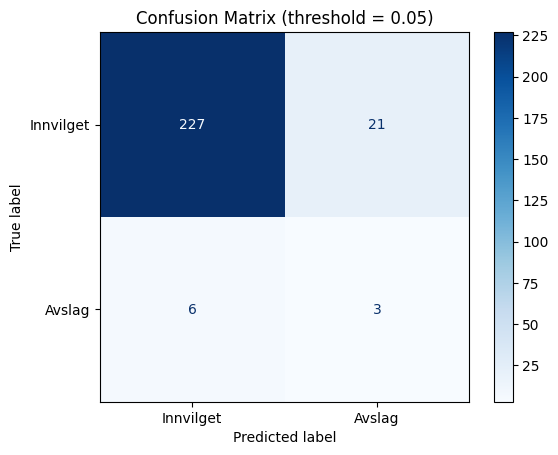

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [45]:
# Detailed metrics per class
print("Classification Report Logistic regression:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Logistic regression:
              precision    recall  f1-score   support

           0     0.9742    0.9153    0.9439       248
           1     0.1250    0.3333    0.1818         9

    accuracy                         0.8949       257
   macro avg     0.5496    0.6243    0.5628       257
weighted avg     0.9445    0.8949    0.9172       257



In [46]:
model = RandomForestClassifier(n_estimators=5000,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000, n_jobs=-1)

In [47]:
yps=model.predict_proba(X_test)

In [48]:
X_test

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,sving,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj,...,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind sving_sigmoid bakke,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind sving_sigmoid bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind sving_sigmoid antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind bakke bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind bakke antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind bakke_sigmoid antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid bakke bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid bakke antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid bakke_sigmoid antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke bakke_sigmoid antall_lange_kj
711,-1.521145,2.514605,1.088215,0.293039,-1.048636,-1.123036,-1.139155,-1.000100,1.064664,-0.555170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
603,0.064912,0.029680,-1.027326,0.293039,0.892410,-1.123036,-1.139155,0.997374,1.064664,0.051848,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,0.327901,1.302542,1.088215,0.293039,0.611224,1.136072,1.026208,0.742191,-0.424325,0.735300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,2.153371,0.029680,-0.377069,1.586506,1.776934,1.351943,1.362996,-0.822329,0.137674,2.171855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,0.270319,0.751545,1.088215,-1.160739,0.611224,0.378524,0.521072,-0.322692,-1.258106,0.494226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,-1.529887,-0.267561,1.088215,0.517489,-1.048636,1.160173,1.059690,-0.908705,-0.368666,-1.590415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,-1.529887,-0.267561,1.088215,-0.437300,-1.048636,1.210878,1.134160,0.473574,-0.244702,-1.590415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
405,1.210011,-0.267561,-1.027326,-0.636108,1.466274,0.479278,0.546676,1.238814,-1.216118,1.115524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239,-0.738563,-0.267561,-0.377069,1.306342,0.122063,-1.123036,-1.139155,-0.517695,1.064664,-0.839320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


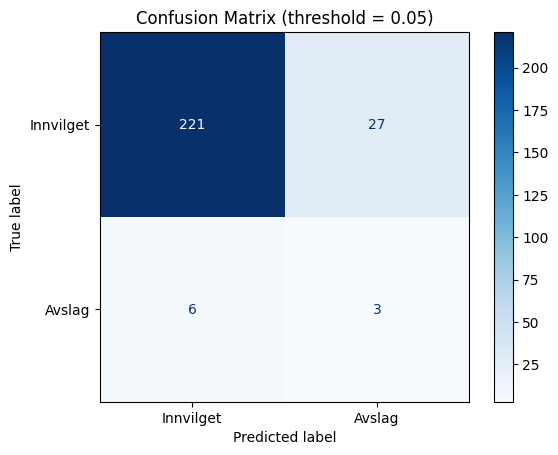

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [50]:
# Detailed metrics per class
print("Classification Report Random Forrest:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Random Forrest:
              precision    recall  f1-score   support

           0     0.9736    0.8911    0.9305       248
           1     0.1000    0.3333    0.1538         9

    accuracy                         0.8716       257
   macro avg     0.5368    0.6122    0.5422       257
weighted avg     0.9430    0.8716    0.9033       257



In [51]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

In [52]:
print(importances_sorted)

Fartsgrense Avkjørsel, holdningsklasse_Lite streng EGS.BRUKSOMRÅDE.1256_Gardsbruk bakke antall_lange_kj                                      0.001679
Funksjonsklasse_E - Lokale adkomstveger EGS.BRUKSOMRÅDE.1256_Gardsbruk bakke antall_lange_kj                                                 0.001585
Avkjørsler Funksjonsklasse_E - Lokale adkomstveger EGS.BRUKSOMRÅDE.1256_Gardsbruk bakke_sigmoid                                              0.001486
ÅDT, andel lange kjøretøy Fartsgrense Avkjørsler Avkjørsel, holdningsklasse_Lite streng EGS.BRUKSOMRÅDE.1256_Gardsbruk                       0.001486
Fartsgrense Avkjørsler Avkjørsel, holdningsklasse_Lite streng EGS.BRUKSOMRÅDE.1256_Gardsbruk bakke                                           0.001480
                                                                                                                                               ...   
ÅDT, total Funksjonsklasse_B - Regionale hovedveger EGS.BRUKSOMRÅDE.1256_Bolig EGS.BRUKSOMRÅDE.1256_

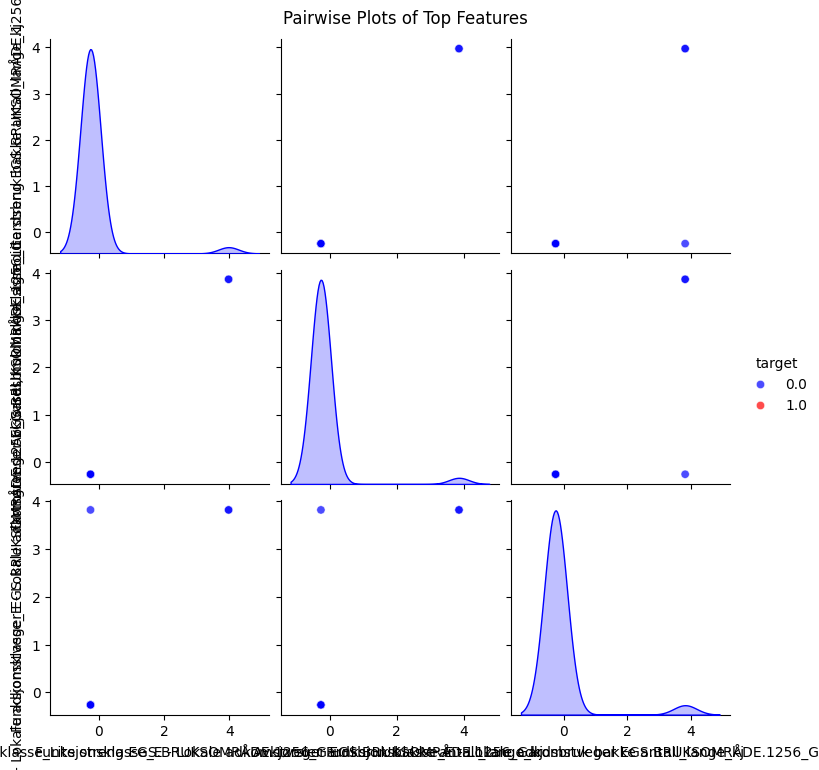

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 4 features
top_features = importances_sorted.index[:3]

# Subset data
X_top = X_test[top_features].copy()
X_top['target'] = y_test  # add the target

# Subset data
#X_top = X_train[top_features].copy()
#X_top['target'] = y_train  # add the target


# Pairwise scatter plots
sns.pairplot(
    X_top,
    vars=top_features,
    hue='target',            # color by target
    palette={0: "blue", 1: "red"}, 
    plot_kws={'alpha': 0.7}
)
plt.suptitle("Pairwise Plots of Top Features", y=1.02)
plt.show()

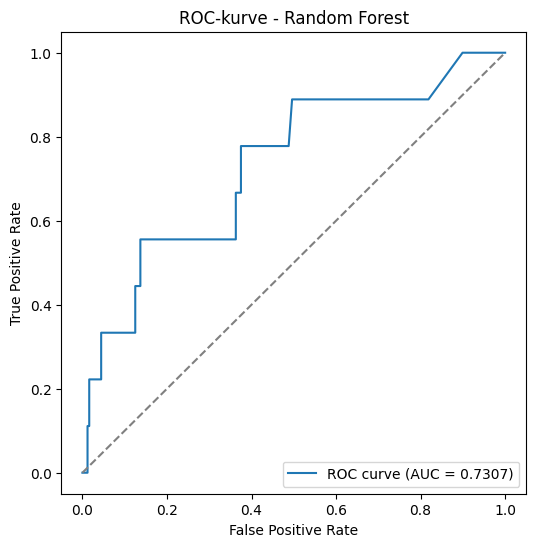

In [54]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Sannsynligheter for den positive klassen
y_proba = model.predict_proba(X_test)[:, 1]

# Beregn ROC-verdier
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plott ROC-kurve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-kurve - Random Forest')
plt.legend(loc='lower right')
plt.show()

In [55]:
#Kort sagt: hver x-verdi viser hvor mange negative som blir feil, hver y-verdi viser hvor mange positive som blir riktig.

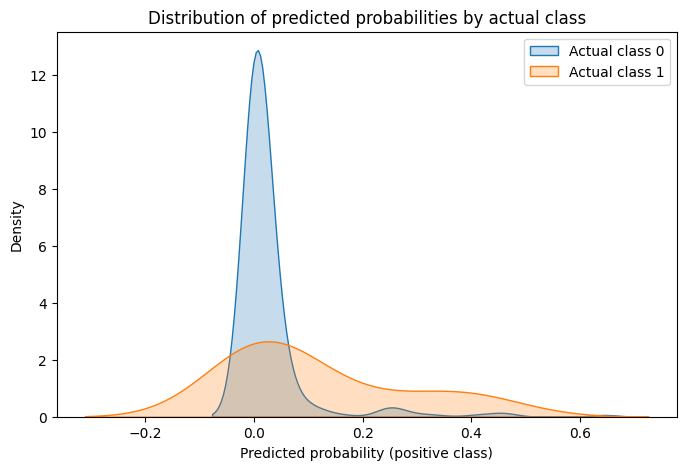

In [56]:
y_proba = yps[:, 1]

# Combine into one DataFrame for easy plotting
import pandas as pd
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [57]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=1000,sampling_strategy=0.3,
                              random_state=42, n_jobs=-1)
model.fit(X_train_orig, y_train_orig)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


In [58]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9715    0.9637    0.9676       248
           1     0.1818    0.2222    0.2000         9

    accuracy                         0.9377       257
   macro avg     0.5767    0.5930    0.5838       257
weighted avg     0.9439    0.9377    0.9407       257



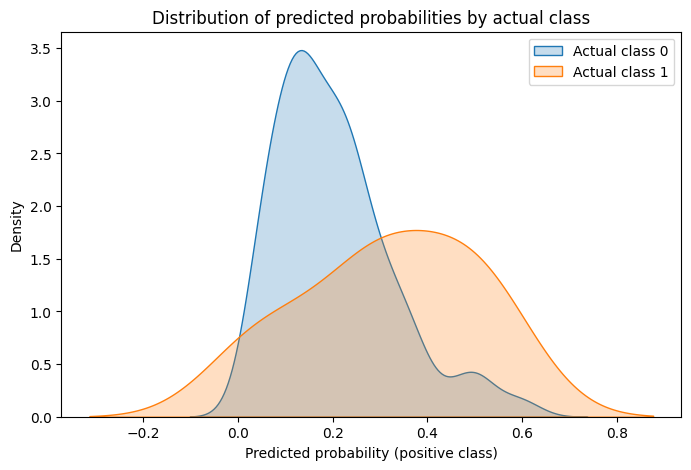

In [59]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [60]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import PredefinedSplit

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 500),
    'sampling_strategy': uniform(0.3, 0.5)
}

model = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, replacement=True, bootstrap=True)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=250,
    cv=4,
    scoring="average_precision",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_orig, y_train_orig)
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Fitting 4 folds for each of 250 candidates, totalling 1000 fits
Best parameters: {'n_estimators': 100, 'sampling_strategy': 0.5211761148655523}
Best score: 0.04860840914835813


In [61]:
y_pred = random_search.predict(X_test)
y_proba = random_search.predict_proba(X_test)[:,1]

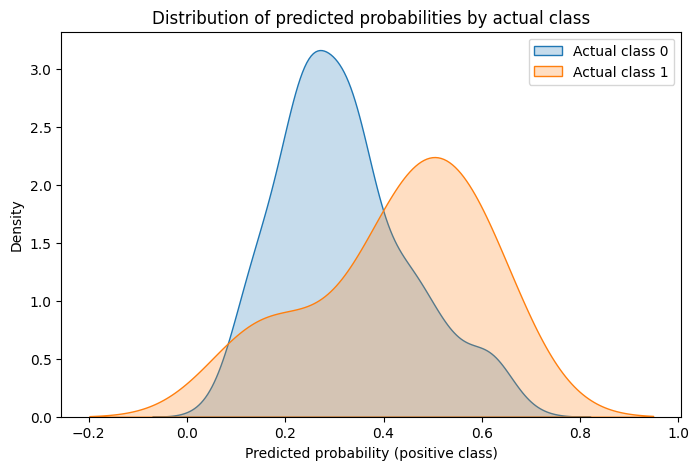

In [62]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

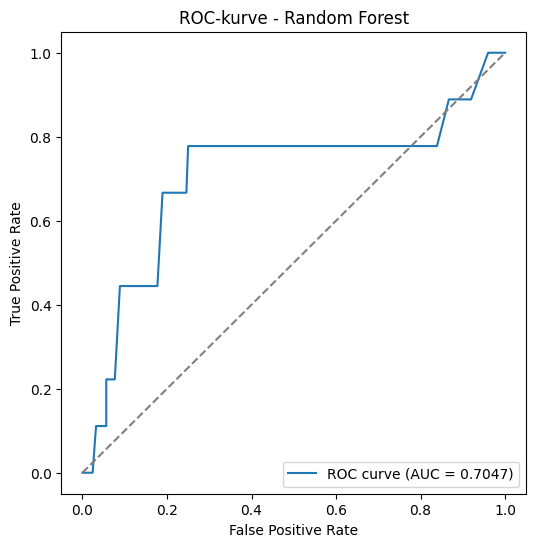

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Sannsynligheter for den positive klassen
y_proba = random_search.predict_proba(X_test)[:, 1]

# Beregn ROC-verdier
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plott ROC-kurve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-kurve - Random Forest')
plt.legend(loc='lower right')
plt.show()

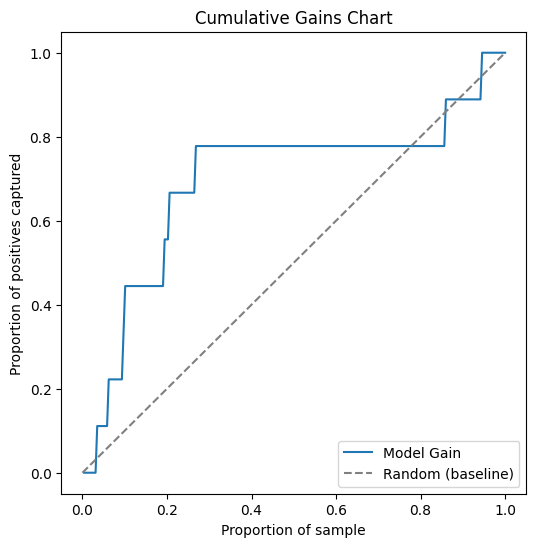

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

y_proba = random_search.predict_proba(X_test)[:,1]

# Create a DataFrame for convenience
df = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_proba
})

# Sort by predicted probability descending
df = df.sort_values('y_proba', ascending=False).reset_index(drop=True)

# Create cumulative counts & proportions
df['cum_true']  = df['y_true'].cumsum()
df['cum_size']  = np.arange(1, len(df)+1)

# Total positives and total size
total_positives = df['y_true'].sum()
total_size      = len(df)

# Compute cumulative gain: proportion of positives captured vs total positives
df['gain'] = df['cum_true'] / total_positives

# Compute population proportion: how many of the cases considered
df['pop_pct'] = df['cum_size'] / total_size

# Plot the gain curve
plt.figure(figsize=(6,6))
plt.plot(df['pop_pct'], df['gain'], label='Model Gain')
plt.plot([0,1], [0,1], linestyle='--', color='grey', label='Random (baseline)')
plt.xlabel('Proportion of sample')
plt.ylabel('Proportion of positives captured')
plt.title('Cumulative Gains Chart')
plt.legend(loc='lower right')
plt.show()


In [65]:
y_proba = random_search.predict_proba(X_test)[:, 1]
y_true=y_test
df = pd.DataFrame({
    'y_true': y_true,
    'y_proba': y_proba
})

In [66]:
bins = np.linspace(0, 1, 5)   # 20 intervals

df["bin"] = pd.cut(df["y_proba"], bins)

table = df.groupby("bin").agg(
    n_samples=("y_true", "count"),
    positives=("y_true", "sum"),
    positive_rate=("y_true", "mean"),
)

table = table.sort_index(ascending=False)
table


C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\985983215.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby("bin").agg(


,n_samples,positives,positive_rate
bin,,,
"(0.75, 1.0]",0,0,NaN
"(0.5, 0.75]",29,4,0.137931
"(0.25, 0.5]",131,3,0.022901
"(0.0, 0.25]",97,2,0.020619


In [67]:
y_true.sum()

9

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_29148\848374661.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby("bin").agg(


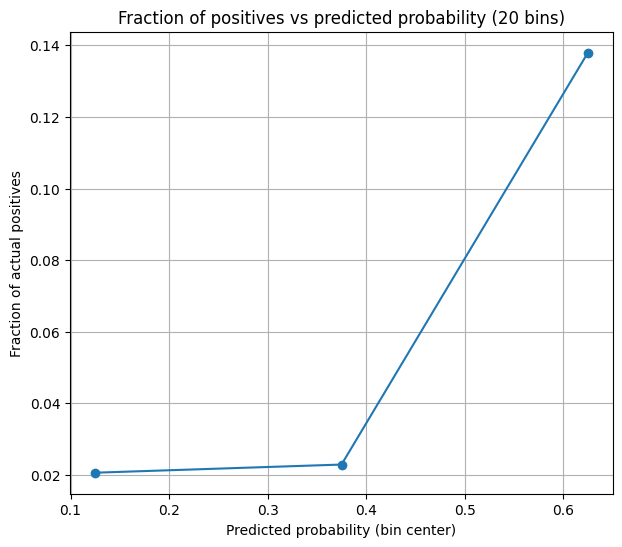

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Predicted probability for positive class
y_proba = random_search.predict_proba(X_test)[:, 1]
y_true  = y_test

df = pd.DataFrame({"y_true": y_true, "y_proba": y_proba})

# Make 20 fixed bins from 0 to 1
bins = np.linspace(0, 1, 5)
df["bin"] = pd.cut(df["y_proba"], bins=bins, include_lowest=True)

# Aggregate: fraction of true positives in each bin
table = df.groupby("bin").agg(
    n_samples=("y_true", "count"),
    positives=("y_true", "sum"),
    positive_rate=("y_true", "mean"),
)

# Compute bin centers for plotting
table["bin_center"] = [interval.mid for interval in table.index]

# Plot
plt.figure(figsize=(7,6))
plt.plot(table["bin_center"], table["positive_rate"], marker="o")
plt.xlabel("Predicted probability (bin center)")
plt.ylabel("Fraction of actual positives")
plt.title("Fraction of positives vs predicted probability (20 bins)")
plt.grid(True)
plt.show()



In [69]:
y_test.sum()

9

In [70]:
y_train.sum()

176